# Sentiment model with CNNs

In [1]:
#Imports 
from __future__ import print_function

import tensorflow as tf
print(tf.__version__)

0.12.0


## Read data and create sequences

In [2]:
#Imports 
import numpy as np
import os
import shutil
import fnmatch

from collections import OrderedDict
from nltk import word_tokenize

data_path='/home/ubuntu/data/training/keras/aclImdb/'



# Generator of list of files in a folder and subfolders
def gen_find(filepath,top):
    for path, dirlist, filelist in os.walk(top):
        for name in fnmatch.filter(filelist,filepath):
            yield os.path.join(path,name)

def read_sentences(path):
    sentences = []
    sentences_list = gen_find("*.txt", path)
    for ff in sentences_list:
        with open(ff, 'r') as f:
            sentences.append(f.readline().strip())
    return sentences 

def tokenize(sentences):
    print( 'Tokenizing...',)
    tokens = []
    for sentence in sentences:
        tokens += [word_tokenize(sentence.decode('utf-8'))]
    print('Done!')
    return tokens

def build_dict(sentences):
    print( 'Building dictionary..',)
    wordcount = dict()
    for ss in sentences:
        for w in ss:
            if w not in wordcount:
                wordcount[w] = 1
            else:
                wordcount[w] += 1

    counts = wordcount.values()
    keys = wordcount.keys()
    sorted_idx = np.argsort(counts)[::-1]

    worddict = dict()
    for idx, ss in enumerate(sorted_idx):
        worddict[keys[ss]] = idx+1  # leave 0 (UNK)
    print( np.sum(counts), ' total words ', len(keys), ' unique words')
    return worddict, wordcount

def generate_sequence(sentences, dictionary):
    seqs = [None] * len(sentences)
    for idx, ss in enumerate(sentences):
        seqs[idx] = [dictionary[w] if w in dictionary else 1 for w in ss]
    return seqs

#Data extraction

#Extract training sentences
sentences_trn_pos = tokenize(read_sentences(data_path+'train/pos/'))
sentences_trn_neg = tokenize(read_sentences(data_path+'train/neg/'))
sentences_trn = sentences_trn_pos + sentences_trn_neg

#Build train dictionary
worddict, wordcount = build_dict(sentences_trn)

#Generate train data
train_x_pos = generate_sequence(sentences_trn_pos, worddict)
train_x_neg = generate_sequence(sentences_trn_neg, worddict)
X_train_full = train_x_pos + train_x_neg
y_trn = np.array([[1.,0.]]*len(train_x_pos) + [[0.,1.]]*len(train_x_neg), dtype=np.float32)


#Read test sentences and generate target y
sentences_tst_pos = read_sentences(data_path+'test/pos/')
sentences_tst_neg = read_sentences(data_path+'test/neg/')

test_x_pos = generate_sequence(tokenize(sentences_tst_pos), worddict)
test_x_neg = generate_sequence(tokenize(sentences_tst_neg), worddict)
X_test_full = test_x_pos + test_x_neg
y_tst = np.array([[1.,0.]]*len(test_x_pos) + [[0.,1.]]*len(test_x_neg), dtype=np.float32)


print('Preprocess done!')

Tokenizing...
Done!
Tokenizing...
Done!
Building dictionary..
7056193  total words  135098  unique words
Tokenizing...
Done!
Tokenizing...
Done!
Preprocess done!


In [3]:
max_features = 20000 # Number of most frequent words selected. the less frequent recode to 0
max_len = 100  # cut texts after this number of words (among top max_features most common words)


#Select the most frequent max_features, recode others using 0
def remove_features(x):
    return [[0 if w >= max_features else w for w in sen] for sen in x]

X_train = remove_features(X_train_full)
X_test  = remove_features(X_test_full)


# Shuffle data
from sklearn.utils import shuffle
X_train, y_trn = shuffle(X_train, y_trn, random_state=0)


# Cut or complete the sentences to length = maxlen
from keras.preprocessing import sequence

print("Pad sequences (samples x time)")
X_trn = sequence.pad_sequences(X_train, maxlen=max_len)
X_tst = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train shape:', X_trn.shape)
print('X_test shape:', X_tst.shape)


Using TensorFlow backend.


Pad sequences (samples x time)
X_train shape: (25000, 100)
X_test shape: (25000, 100)


## The model

In [4]:
# Model parameters

sequence_length = 100
vocab_size = 20000

embedding_size = 128
num_filters = 128
filter_sizes = [3, 4, 5]

LOG_DIR = '/tmp/tensorboard/sentiment_cnn'



In [5]:
# Start an interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))

In [6]:
# Inputs
input_x = tf.placeholder(tf.int32, shape=[None, sequence_length], name="input_x")
input_y = tf.placeholder(tf.int32, shape=[None, 2], name="input_y")
dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

# Embedding layer
with tf.name_scope("embedding"):
    W_embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W_embedding")
    embedded_chars = tf.nn.embedding_lookup(W_embedding, input_x)
    embedded_chars_expanded = tf.expand_dims(embedded_chars, -1)

    
# Create a convolution + maxpool layer for each filter size
def conv_layer(x, size_x=2, size_y=2, input_channels=1, output_channels=32):
    W_conv = tf.Variable(tf.truncated_normal([size_x, size_y, input_channels, output_channels], stddev=0.1), name='W')
    b_conv = tf.Variable(tf.constant(0.1, shape=[output_channels]), name='b')
    conv_out = tf.nn.relu(tf.nn.conv2d(x, W_conv, strides=[1, 1, 1, 1], padding='VALID') + b_conv, name='conv')
    pooled = tf.nn.max_pool(conv_out, ksize=[1, sequence_length - filter_size + 1, 1, 1], 
                            strides=[1, 1, 1, 1], padding='VALID', name="pool")
    return pooled

pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):
    with tf.name_scope("conv-maxpool-%s" % filter_size):
        pooled = conv_layer(embedded_chars_expanded, size_x=filter_size, size_y=embedding_size, input_channels=1, output_channels=num_filters)
        pooled_outputs.append(pooled)

# Combine all the pooled features
num_filters_total = num_filters * len(filter_sizes)
h_pool = tf.concat(3, pooled_outputs)
h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])    

# Add dropout
with tf.name_scope("dropout"):
    h_drop = tf.nn.dropout(h_pool_flat, dropout_keep_prob)

# Final (unnormalized) scores and predictions
with tf.name_scope("output"):
    W = tf.get_variable("W", shape=[num_filters_total, 2], initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.constant(0.1, shape=[2]), name="b")
    
    l2_loss = tf.nn.l2_loss(W)
    l2_loss += tf.nn.l2_loss(b)

    scores = tf.nn.xw_plus_b(h_drop, W, b, name="scores")
    predictions = tf.argmax(scores, 1, name="predictions")
    
# Calculate Mean cross-entropy loss
loss_factor = 0.1

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(scores, input_y), name='loss') + loss_factor * l2_loss
    loss_summ = tf.scalar_summary("Loss", loss) #TENSORBOARD

# Accuracy
with tf.name_scope("accuracy"):
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, tf.argmax(input_y, 1)), "float"), name="accuracy")
    acc_summ = tf.scalar_summary("Accuracy", accuracy) #TENSORBOARD
    
#Optimizer
with tf.name_scope("train") as scope:
    train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)



Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


In [7]:
# Merge all the summaries and write them out to /tmp/mnist_logs
with tf.name_scope('summaries') as scope:
    merged = tf.merge_all_summaries()
    train_writer = tf.train.SummaryWriter(LOG_DIR + '/train', sess.graph)
    test_writer  = tf.train.SummaryWriter(LOG_DIR + '/test')

'''
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR + '/train', sess.graph)
    test_writer  = tf.summary.FileWriter(LOG_DIR + '/test')
'''

Instructions for updating:
Please switch to tf.summary.merge_all.
Instructions for updating:
Please switch to tf.summary.merge.
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


"\n    merged = tf.summary.merge_all()\n    train_writer = tf.summary.FileWriter(LOG_DIR + '/train', sess.graph)\n    test_writer  = tf.summary.FileWriter(LOG_DIR + '/test')\n"

## Batch iterator

In [8]:
def batch_iter(X, y, batch_size):
    """
    Generates a batch iterator for inputs and targets.
    """
    data_size = len(X)
    # Shuffle the data at each epoch
    shuffle_indices = np.random.permutation(np.arange(data_size))    
    shuffled_X = X[shuffle_indices]
    shuffled_y = y[shuffle_indices]
        
    num_batches = int((data_size-1)/batch_size) + 1
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        yield shuffled_X[start_index:end_index], shuffled_y[start_index:end_index]


## Train iterator

In [9]:
#Inicialization.
sess.run(tf.global_variables_initializer())

# Train proccess
num_epochs = 20
batch_size = 128

step_trn = 0
step_tst = 0

loss_trn_epoch = []
loss_tst_epoch = []
acc_trn_epoch = []
acc_tst_epoch = []

for epoch in range(num_epochs):
    loss_trn = []
    acc_trn = []
    loss_tst = []
    acc_tst = []
    for x_batch, y_batch in batch_iter(X_trn, y_trn, batch_size):
        train_step.run(feed_dict={input_x: x_batch, input_y: y_batch, dropout_keep_prob: 0.5})
        loss_step, acc_step = sess.run([loss, accuracy], 
                                       feed_dict={input_x: x_batch, input_y: y_batch, dropout_keep_prob: 1})
        loss_trn += [loss_step]
        acc_trn += [acc_step]
        
        # Summary over the last batch of the epoch
        step_trn += 1
        if step_trn % 10 ==0 :
            summary_str = merged.eval(feed_dict={input_x: x_batch, input_y: y_batch, dropout_keep_prob: 1})
            train_writer.add_summary(summary_str, step_trn) #TENSORBOARD
        
    
    for x_batch_test, y_batch_test in batch_iter(X_tst, y_tst, batch_size):
        loss_step, acc_step = sess.run([loss, accuracy], 
                                       feed_dict={input_x: x_batch_test, input_y: y_batch_test, dropout_keep_prob: 1})
        loss_tst += [loss_step]
        acc_tst += [acc_step]
        
        # Summary over the last batch of the epoch
        step_tst += 1 
        if step_tst % 10 ==0 :
            summary_str = merged.eval(feed_dict={input_x: x_batch_test, input_y: y_batch_test, dropout_keep_prob: 1})
            test_writer.add_summary(summary_str, step_tst) #TENSORBOARD

    print(epoch, np.mean(loss_trn), np.mean(acc_trn), np.mean(loss_tst), np.mean(acc_tst))
    loss_trn_epoch += [np.mean(loss_trn)]
    loss_tst_epoch += [np.mean(loss_tst)]
    acc_trn_epoch += [np.mean(acc_trn)]
    acc_tst_epoch += [np.mean(acc_tst)]
    

0 0.856838 0.633363 0.695024 0.690761
1 0.616173 0.760172 0.648631 0.719077
2 0.597695 0.764429 0.619368 0.734351
3 0.552696 0.787364 0.580381 0.750534
4 0.495948 0.816661 0.528921 0.782071
5 0.441336 0.845344 0.500374 0.780556
6 0.39054 0.861519 0.491239 0.777487
7 0.332692 0.888624 0.426675 0.818814
8 0.279159 0.913504 0.414833 0.822585
9 0.231079 0.931832 0.403756 0.830748
10 0.186956 0.949649 0.395134 0.836663
11 0.147457 0.965314 0.409288 0.835188
12 0.115046 0.978077 0.427448 0.832047
13 0.0905444 0.987604 0.453924 0.831824
14 0.0741136 0.992985 0.482307 0.829265
15 0.0611654 0.996333 0.499616 0.82771
16 0.052854 0.998326 0.517827 0.826634
17 0.0464961 0.999163 0.535525 0.824187
18 0.042229 0.999633 0.554737 0.823422
19 0.0386121 0.999841 0.556324 0.823956
20 0.0358642 0.99988 0.57023 0.823414
21 0.0335095 0.99996 0.575433 0.822146
22 0.0313103 0.99992 0.584607 0.821819
23 0.0293914 1.0 0.592051 0.820113
24 0.0278609 1.0 0.598525 0.820161
25 0.0264796 1.0 0.606677 0.819627
26 0.0

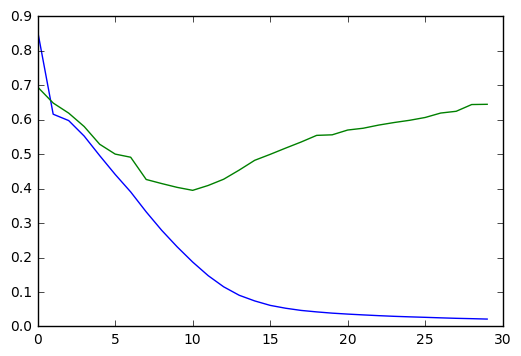

In [10]:
# Plot a scaterplot real vs predict
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(loss_trn_epoch)
plt.plot(loss_tst_epoch)
plt.show()

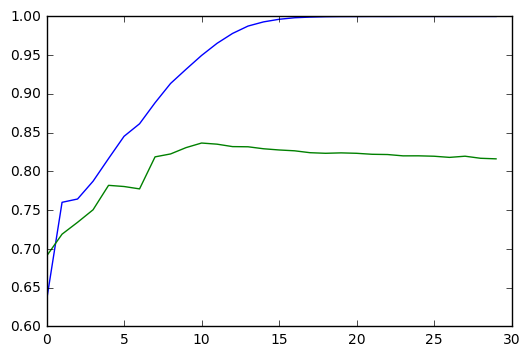

In [11]:
plt.plot(acc_trn_epoch)
plt.plot(acc_tst_epoch)
plt.show()